# Gaussian Mixture Models

## **1. What is a Generative Model?**  
A model that learns the **joint probability distribution** $P(X, Y)$ or $P(X)$ and generates new data similar to the training data.  

---

## **2. Objective of a Generative Model**  
- Learn the **underlying distribution** of data.  
- **Generate new samples** resembling the training data.  

---

## **3. Generative vs Discriminative Models**

| **Aspect**         | **Generative**                    | **Discriminative**              |
|---------------------|----------------------------------|---------------------------------|
| **Goal**           | Learn $P(X, Y)$ or $P(X)$        | Learn $P(Y | X)$                |
| **Focus**          | Data generation & density        | Classification/prediction       |
| **Examples**       | GMMs, GANs, VAEs                 | Logistic Regression, SVM        |

---

## **4. Variance-Covariance Matrix**  
A matrix showing variances and covariances:  
- **Diagonal**: Variances of variables.  
- **Off-diagonal**: Covariances between variables.  

**Formula**:  

$$
\Sigma_{ij} = \text{Cov}(X_i, X_j) = E\left[(X_i - \mu_i)(X_j - \mu_j)\right]
$$  

---

## **5. Gaussian Mixture Model (GMM)**  
A GMM models data as a mixture of $K$ Gaussian distributions:  

$$
P(X) = \sum_{k=1}^K \pi_k \mathcal{N}(X | \mu_k, \Sigma_k)
$$  

- $\pi_k$: Mixing coefficients $(\sum \pi_k = 1)$.  
- $\mu_k, \Sigma_k$: Mean and covariance of Gaussian $k$.  

---

## **6. Is GMM a Generative Model?**  
Yes, GMM generates data by:  
1. Sampling a Gaussian component $k$ using $\pi_k$.  
2. Sampling a point $X$ from $\mathcal{N}(\mu_k, \Sigma_k)$.

---

## **7. Training GMM: EM Algorithm**  
1. **Initialize**: Start with $\pi_k, \mu_k, \Sigma_k$.  
2. **E-Step**: Compute **responsibilities** $r_{ik}$:  

   $$
   r_{ik} = \frac{\pi_k \mathcal{N}(X_i | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(X_i | \mu_j, \Sigma_j)}
   $$  

3. **M-Step**: Update parameters:  
   - **Means**:  
     $ \mu_k = \frac{\sum_i r_{ik} X_i}{\sum_i r_{ik}} $  
   - **Covariances**:  
     $ \Sigma_k = \frac{\sum_i r_{ik} (X_i - \mu_k)(X_i - \mu_k)^T}{\sum_i r_{ik}} $  
   - **Mixing Coefficients**:  
     $ \pi_k = \frac{1}{N} \sum_i r_{ik} $  
4. **Repeat** until convergence.

---

## **8. GMM for Anomaly Detection**  
- **Step 1**: Fit GMM to the data.  
- **Step 2**: Compute the density $P(X)$ for each point.  
- **Step 3**: Define a **threshold**: Points with very low $P(X)$ are anomalies.  
- **Result**:  
   - High-density regions = normal.  
   - Low-density regions = anomalies.


In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(47)
plt.style.use('dark_background')
plt.rc('axes', titlesize=24, labelsize=15, 
       labelpad=5)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)              
plt.rc('legend', fontsize=12)

In [3]:
means = np.array([[0, 0], [5, 5], [-5, 5]])
covariances = np.array([
    [[1, 0], [0, 1]], 
    [[1, 0], [0, 1]], 
    [[1, 0], [0, 1]]]
)
n_total_samples = 2500
n_samples_component = [n_total_samples // 3] * 3  

In [4]:
X_true = np.vstack([
    np.random.multivariate_normal(
        means[0], covariances[0],
        n_samples_component[0]),
    np.random.multivariate_normal(
        means[1], covariances[1], 
        n_samples_component[1]),
    np.random.multivariate_normal(
        means[2], covariances[2], 
        n_samples_component[2])
])

In [5]:
X_with_outliers = np.vstack([
    X_true, 
    np.random.uniform(low=-10, high=10, size=(50, 2))
])

In [6]:
y_true = np.array(
    [0] * n_samples_component[0] + 
    [1] * n_samples_component[1] + 
    [2] * n_samples_component[2] + [3] * 50
)

In [7]:
# Fit a Gaussian Mixture Model (GMM) to the data
clf_gmm = GaussianMixture(n_components=3, 
                          covariance_type='full')
clf_gmm.fit(X_with_outliers)

GaussianMixture(n_components=3)

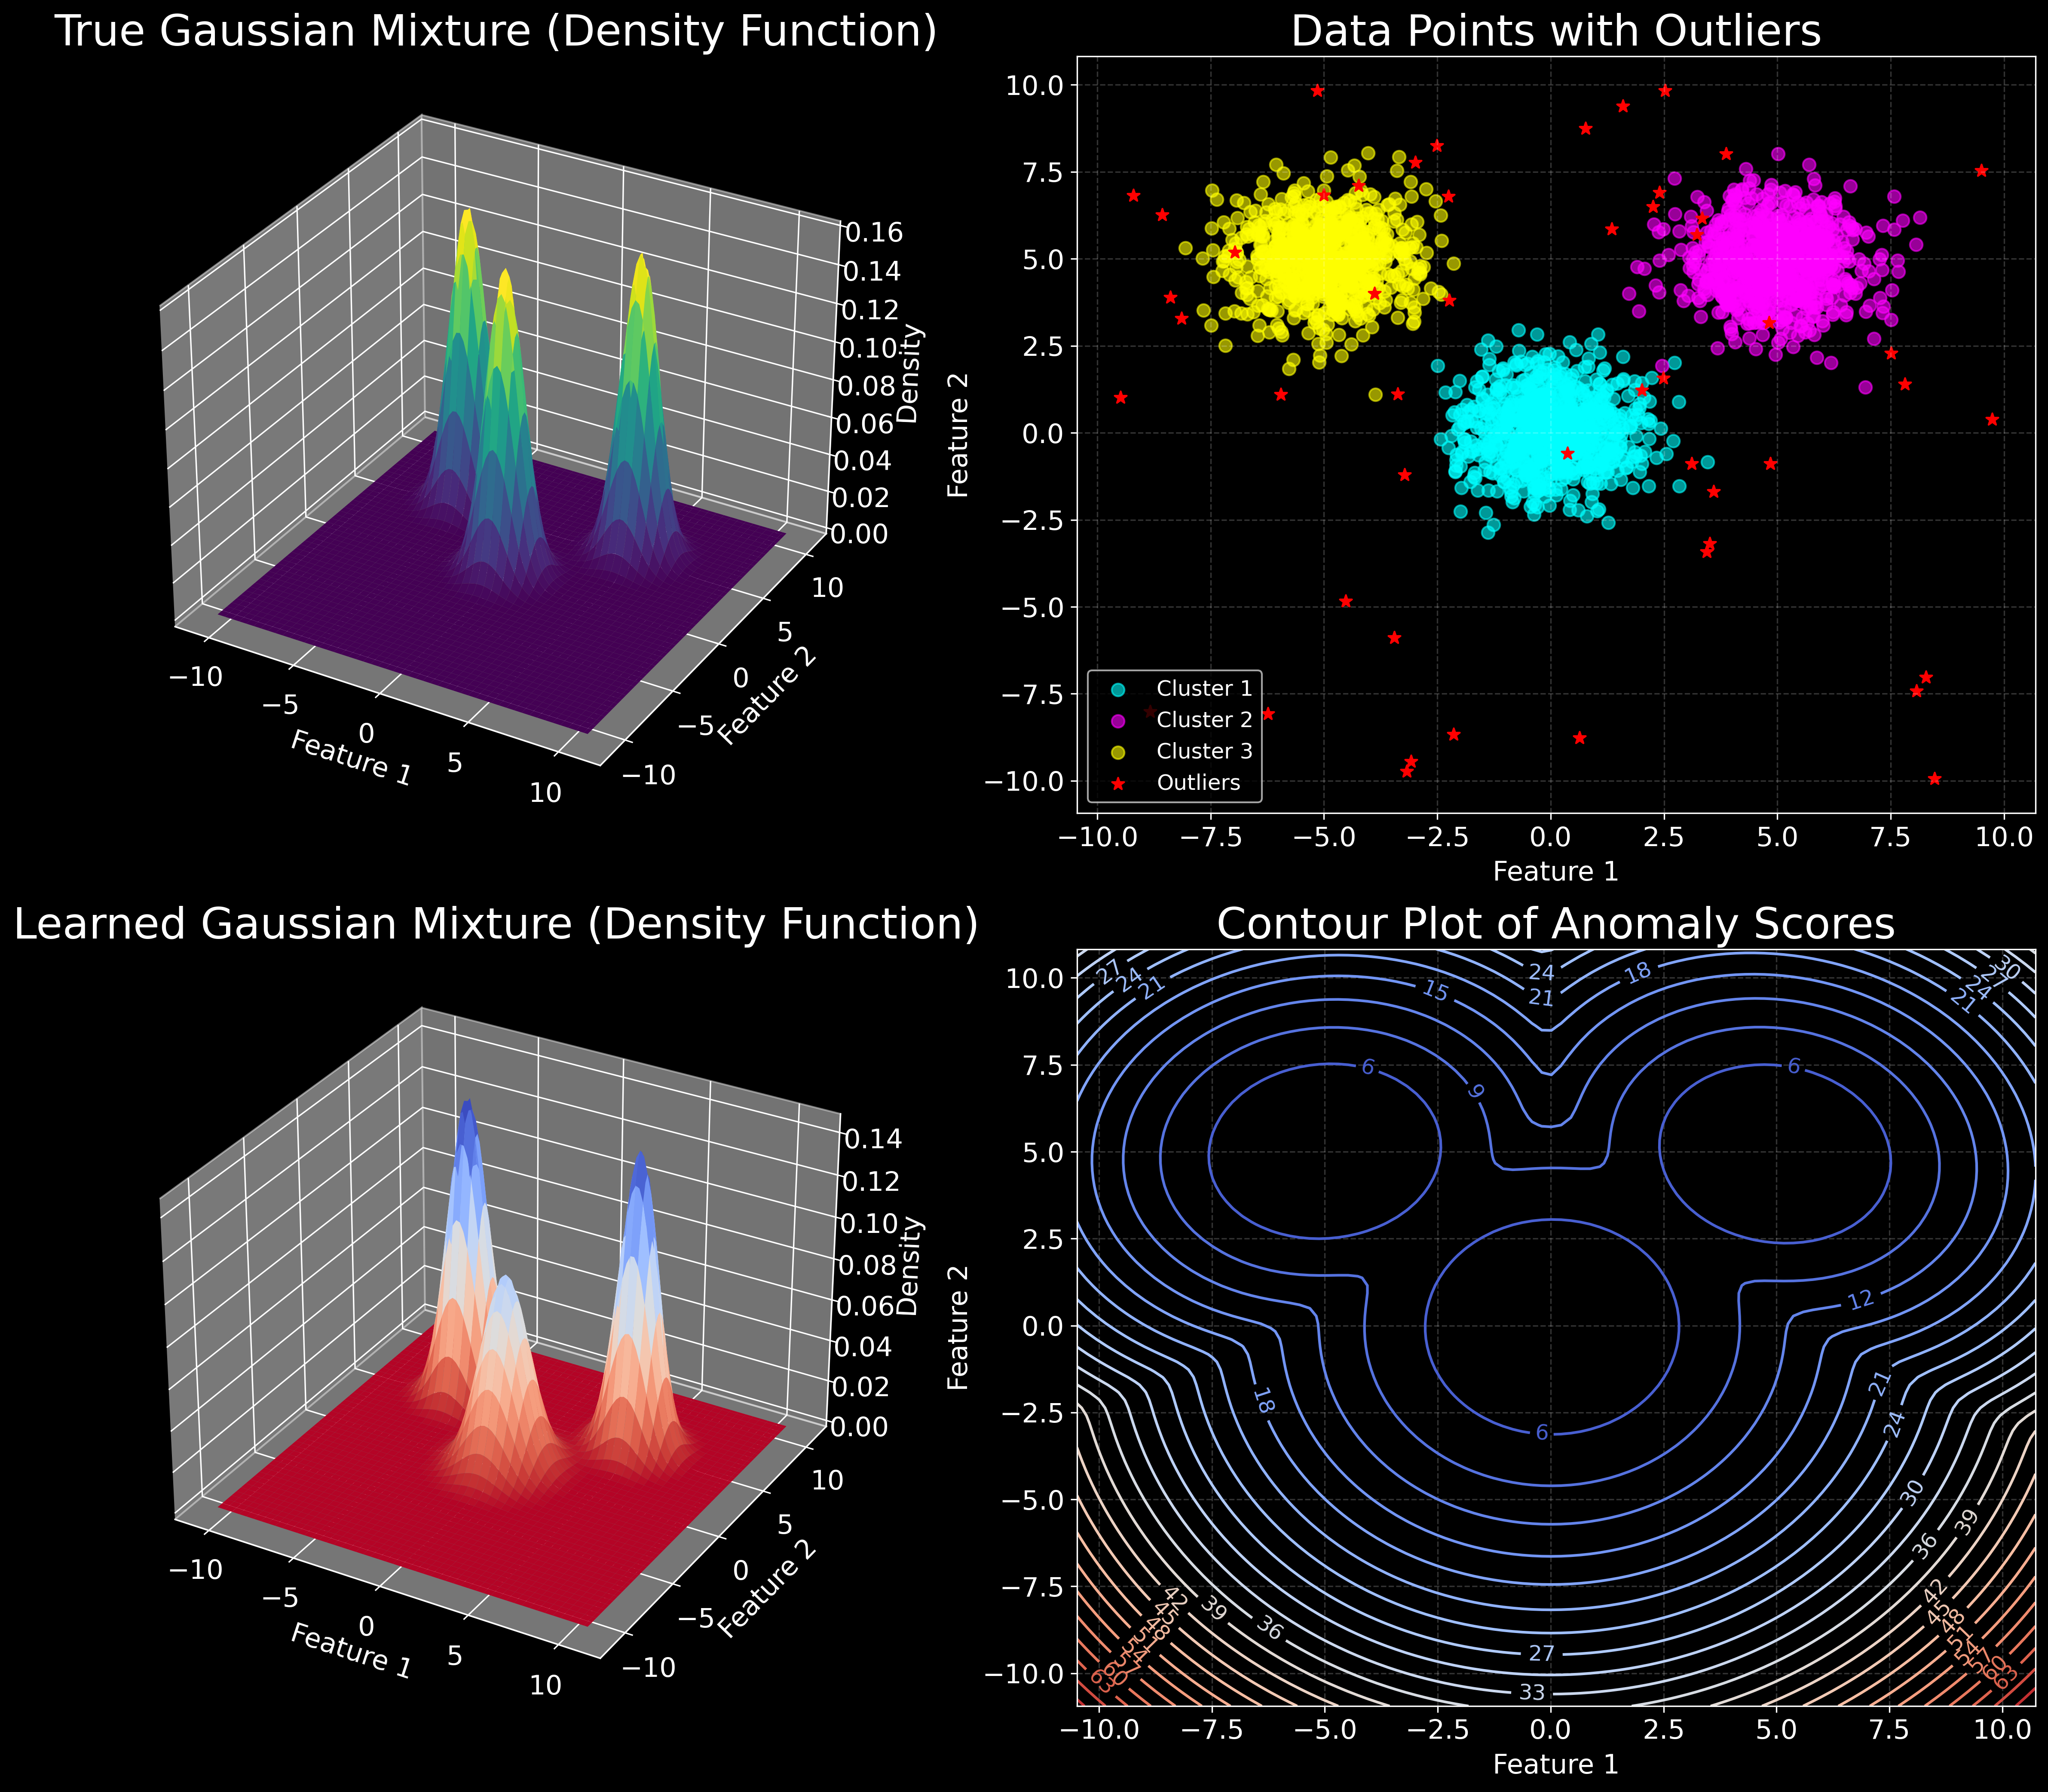

In [8]:
# Prepare the grid for contour and surface plots
xx, yy = np.meshgrid(np.linspace(X_with_outliers[:, 0].min() - 1, X_with_outliers[:, 0].max() + 1, 100),
                     np.linspace(X_with_outliers[:, 1].min() - 1, X_with_outliers[:, 1].max() + 1, 100))

# Function to calculate the PDF of a Gaussian Mixture Model
def calculate_pdf(X, means, covariances):
    Z = np.zeros(X.shape[0])
    for i in range(len(means)):
        rv = multivariate_normal(means[i], covariances[i])
        Z += rv.pdf(X)
    return Z

# Function to plot a 3D surface plot
def plot_3d_surface(ax, X, Z, title, cmap="viridis"):
    ax.plot_surface(X[0], X[1], Z, cmap=cmap, edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Density')

# Create a 2x2 grid of plots
fig = plt.figure(figsize=(16, 14), dpi=300)

# Plot 1: True Gaussian Mixture (Density Function) - 3D Surface Plot
Z_true = calculate_pdf(np.c_[xx.ravel(), yy.ravel()], means, covariances).reshape(xx.shape)
ax1 = fig.add_subplot(221, projection='3d')
plot_3d_surface(ax1, (xx, yy), Z_true, 'True Gaussian Mixture (Density Function)', cmap="viridis")

# Plot 2: Scatter Plot of Data Points with Outliers
ax2 = fig.add_subplot(222)
ax2.scatter(X_with_outliers[y_true == 0][:, 0], X_with_outliers[y_true == 0][:, 1], c='cyan', label='Cluster 1', s=50, alpha=0.6)
ax2.scatter(X_with_outliers[y_true == 1][:, 0], X_with_outliers[y_true == 1][:, 1], c='magenta', label='Cluster 2', s=50, alpha=0.6)
ax2.scatter(X_with_outliers[y_true == 2][:, 0], X_with_outliers[y_true == 2][:, 1], c='yellow', label='Cluster 3', s=50, alpha=0.6)
ax2.scatter(X_with_outliers[y_true == 3][:, 0], X_with_outliers[y_true == 3][:, 1], c='red', label='Outliers', s=50, marker='*')
ax2.set_title('Data Points with Outliers')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()
ax2.grid(True, alpha=0.2, linestyle='--')

# Plot 3: Learned Gaussian Mixture (Density Function) - 3D Surface Plot
Z_learned = calculate_pdf(np.c_[xx.ravel(), yy.ravel()], clf_gmm.means_, clf_gmm.covariances_).reshape(xx.shape)
ax3 = fig.add_subplot(223, projection='3d')
plot_3d_surface(ax3, (xx, yy), Z_learned, 'Learned Gaussian Mixture (Density Function)', cmap="coolwarm_r")

# Plot 4: Contour Plot of Anomaly Scores on Grid
Z_scores = np.zeros_like(xx)
for i, (x1, x2) in enumerate(np.c_[xx.ravel(), yy.ravel()]):
    Z_scores.ravel()[i] = clf_gmm.score_samples([[x1, x2]])
Z_scores = Z_scores.reshape(xx.shape)

ax4 = fig.add_subplot(224)
ax4.scatter(X_with_outliers[y_true == 3][:, 0], X_with_outliers[y_true == 3][:, 1], c='black', label='Outliers', s=50, marker='x')
cs = ax4.contour(xx, yy, np.abs(Z_scores), levels=25, cmap="coolwarm", alpha=1.0)
ax4.clabel(cs, inline=True, fontsize=12)
ax4.set_title('Contour Plot of Anomaly Scores')
ax4.set_xlabel('Feature 1')
ax4.set_ylabel('Feature 2')
ax4.grid(True, alpha=0.2, linestyle='--')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [9]:
print(f"Mixing Coefficients:\n{clf_gmm.weights_}\n")

print("Cluster Means (Coordinates):")
for i, mean in enumerate(clf_gmm.means_):
    print(f"  Cluster {i + 1}: {mean}")
print()

print("Variance-Covariance Matrices:")
for i, cov in enumerate(clf_gmm.covariances_):
    print(f"  Cluster {i + 1}:\n{cov}\n")

Mixing Coefficients:
[0.3313679  0.33212667 0.33650543]

Cluster Means (Coordinates):
  Cluster 1: [4.96969545 4.93619144]
  Cluster 2: [-5.00061852  5.01258156]
  Cluster 3: [ 0.03256241 -0.04007989]

Variance-Covariance Matrices:
  Cluster 1:
[[ 1.11246339 -0.10586276]
 [-0.10586276  1.11809996]]

  Cluster 2:
[[1.11030872 0.05919156]
 [0.05919156 1.06278855]]

  Cluster 3:
[[1.56090914 0.00775952]
 [0.00775952 1.88806446]]

